In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

# Functions

In [3]:
# Definisci una funzione per mappare i paesi alle regioni
def assign_region(country):
    country = HDR_ISO_country[country]
    if country in Asia:
        return 'EAP'
    elif country in Europe_Central_Asia:
        return 'ECA'
    elif country in Weastern_Europe:
        return 'WE'
    elif country in North_America:
        return 'NA'
    elif country in Arab_states:
        return 'AS'
    elif country in Oceania:
        return 'OC'
    elif country in Areas:
        return 'AREA'

In [4]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [ ]:
def Gap(df: pd.DataFrame, inds: list[str]) -> pd.DataFrame:
    """
    For each iso3, find the overall min and max year in df,
    then for each indicator in inds compute newest – oldest.
    
    Returns a DataFrame with columns:
      iso3, min_year, max_year,
      oldest_<ind>, newest_<ind>, <ind>_diff  (one set per indicator)
    """
    # 1) Find global min and max year per country
    year_range = (
        df.groupby('iso3')['year']
          .agg(min_year='min', max_year='max')
          .reset_index()
    )
    
    # 2) Pull out oldest rows
    oldest = (
        df.merge(year_range, on='iso3')
          .query("year == min_year")
          .loc[:, ['iso3', 'year'] + inds]
          .rename(columns={ 'year': 'min_year', 
                            **{ind: f'oldest_{ind}' for ind in inds}})
    )
    
    # 3) Pull out newest rows
    newest = (
        df.merge(year_range, on='iso3')
          .query("year == max_year")
          .loc[:, ['iso3', 'year'] + inds]
          .rename(columns={ 'year': 'max_year', 
                            **{ind: f'newest_{ind}' for ind in inds}})
    )
    
    # 4) Merge them all together
    result = (
        year_range
        .merge(oldest, on='iso3')
        .merge(newest, on='iso3')
    )
    
    # 5) Compute diffs
    for ind in inds:
        result[f'{ind}_diff'] = result[f'newest_{ind}'] - result[f'oldest_{ind}']
    
    return result

# Example usage:
# df has columns ['iso3','year','logGDP','pop','ind1',...]
# gaps = Gap(df, ['logGDP','pop'])


In [5]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('iso3')[ind].shift(1)
    Panel.dropna(subset = shift ,inplace=True) # Drop rows with NaN values
    return Panel

In [6]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['iso3','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['iso3', 'year'])
    # Drop rows with NaN values only in the independent and dependent variable columns
    model_df = model_df.dropna(subset=independent_vars + [dependent_var])
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    return results.summary

# Data loading and preparation

## Data Loading

In [7]:
path = 'Datasets/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data
schooling_labels = pd.read_csv(path+'UNESCO/OPRI_LABEL.csv') # Schooling labels
gs = pd.read_csv(path + 'GenderStatistics/GS.csv') # Globalization data

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_4451/247098959.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data


## Data preparation

In [8]:
GS = gs.copy()
GS = GS.drop(columns=['Unnamed: 0'])
GS = GS.rename(columns={'REF_AREA': 'iso3', 'YEAR': 'year'})

### HDR

In [9]:
HDR_ISO_country = {hdr['iso3'][i]:hdr['country'][i] for i in range(len(hdr))}

In [10]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [11]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [12]:
North_America = ['Canada','United States'] 
Oceania = ['Australia','New Zealand'] 
Asia = ['Hong Kong, China (SAR)','Korea (Republic of)','Japan'] 
Europe_Central_Asia = ['Cyprus','Russian Federation','Israel'] 
Weastern_Europe = ['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 
                   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
                   'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 
                   'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland','United Kingdom']
Arab_states = ['Algeria', 'Bahrain', 'Djibouti', 'Egypt', 'Iraq', 'Jordan']
Areas = ['Very high human development', 'High human development',
       'Medium human development', 'Low human development', 'Arab States',
       'East Asia and the Pacific', 'Europe and Central Asia',
       'Latin America and the Caribbean', 'South Asia',
       'Sub-Saharan Africa', 'World']

In [13]:
region_labels = {
    'ECA': 'Europe & Central Asia',
    'AS':  'Arab States',
    'SSA': 'Sub-Saharan Africa', 
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'EAP': 'East Asia & Pacific',
    'AS':  'Arab States',
    'NA': 'North America',
    'WE': 'Western Europe',
    'OC': 'Oceania'
}

In [14]:
h = HDR[HDR['region'].isna()].copy()
h.loc[:,'region'] = h.loc[:,'iso3'].apply(assign_region)
HDR = pd.concat([HDR[~HDR['region'].isna()], h], ignore_index=True) # Concatenate the two dataframes
HDR.dropna(subset=['value'], inplace=True) # Drop rows with NaN values in the region column
HDR = HDR[HDR['region'] != 'AREA']

In [15]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [16]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [17]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [18]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 
           'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

#### GDP per Capita PPP

In [19]:
WB_ISO_country = {gdp_pc_ppp['REF_AREA_ID'][i]:gdp_pc_ppp['REF_AREA_NAME'][i] for i in range(len(gdp_pc_ppp))}

In [20]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

#### Schooling

In [21]:
SCH = schooling.copy()
SCH['INDICATOR_ID'] = SCH['INDICATOR_ID'].astype(str)
SCH = SCH[SCH['INDICATOR_ID'].str.contains('NART', na=False)] 
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH['YEAR'] = pd.to_datetime(SCH['YEAR'], format='%Y',errors='coerce').dt.year 

In [22]:
Primary = SCH[SCH['INDICATOR_ID'].str.contains('NART.1', na=False)] # Filter for primary education
Secondary = SCH[SCH['INDICATOR_ID'].str.contains('NART.2', na=False)] # Filter for secondary education
Tertiary = SCH[SCH['INDICATOR_ID'].str.contains('NART.3', na=False)] # Filter for tertiary education

In [23]:
P = Primary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
S = Secondary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
T = Tertiary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()

In [24]:
P.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
S.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
T.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)

# Gap

In [25]:
Res = {}

In [90]:
def GapShared(df1: pd.DataFrame, ind1: str,
              df2: pd.DataFrame, ind2: str) -> pd.DataFrame:
    """
    For each iso3, find the overlapping year range between df1 and df2,
    then compute for both indicators at the start and end of that range:
      - <ind>_start, <ind>_end, <ind>_diff
    Returns a DataFrame with columns:
      iso3, common_start_year, common_end_year,
      start_<ind1>, end_<ind1>, diff_<ind1>,
      start_<ind2>, end_<ind2>, diff_<ind2>
    """
    # 1) Compute min/max years per iso3 in each dataset
    df1 = df1.dropna(subset=[ind1])
    df2 = df2.dropna(subset=[ind2])
    y1 = df1.groupby('iso3')['year'].agg(min1='min', max1='max').reset_index()
    y2 = df2.groupby('iso3')['year'].agg(min2='min', max2='max').reset_index()

    # 2) Merge to get per-iso3 common span
    yrs = pd.merge(y1, y2, on='iso3', how='inner')
    yrs['common_start_year'] = yrs[['min1', 'min2']].max(axis=1)
    yrs['common_end_year']   = yrs[['max1', 'max2']].min(axis=1)

    # 3) Filter to only those with a valid overlap
    valid = yrs[yrs['common_start_year'] <= yrs['common_end_year']]

    # 4) Prepare df1 oldest and newest at shared years
    df1_ext = pd.merge(df1, valid[['iso3', 'common_start_year', 'common_end_year']], on='iso3')
    oldest1 = df1_ext[df1_ext['year'] == df1_ext['common_start_year']][['iso3', ind1]]
    newest1 = df1_ext[df1_ext['year'] == df1_ext['common_end_year']][['iso3', ind1]]
    oldest1 = oldest1.rename(columns={ind1: f'start_{ind1}'})
    newest1 = newest1.rename(columns={ind1: f'end_{ind1}'})

    # 5) Prepare df2 oldest and newest at shared years
    df2_ext = pd.merge(df2, valid[['iso3', 'common_start_year', 'common_end_year']], on='iso3')
    oldest2 = df2_ext[df2_ext['year'] == df2_ext['common_start_year']][['iso3', ind2]]
    newest2 = df2_ext[df2_ext['year'] == df2_ext['common_end_year']][['iso3', ind2]]
    oldest2 = oldest2.rename(columns={ind2: f'start_{ind2}'})
    newest2 = newest2.rename(columns={ind2: f'end_{ind2}'})

    # 6) Merge all parts
    result = valid[['iso3', 'common_start_year', 'common_end_year']]
    result = result.merge(oldest1, on='iso3')
    result = result.merge(newest1, on='iso3')
    result[f'diff_{ind1}'] = result[f'end_{ind1}'] - result[f'start_{ind1}']

    result = result.merge(oldest2, on='iso3')
    result = result.merge(newest2, on='iso3')
    result[f'diff_{ind2}'] = result[f'end_{ind2}'] - result[f'start_{ind2}']

    return result


In [91]:
GAP = GapShared(GDP, 'logGDP', GII, HDR_idx['gii'])

In [100]:
GAP_2 = pd.merge(GAP, GS[GS['year']==2023], how='left', on=['iso3'])

In [97]:
GS

,iso3,year,A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),...,The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law grants spouses equal administrative authority over assets during marriage (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
0,AFG,1970,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,AFG,1971,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,AFG,1972,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,AFG,1973,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,AFG,1974,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,ZWE,2019,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
10202,ZWE,2020,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
10203,ZWE,2021,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
10204,ZWE,2022,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [94]:
Panel_GII = GAP.copy()
Y = Panel_GII['diff_logGDP']
X = Panel_GII['diff_'+HDR_idx['gii']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     15.24
Date:                Tue, 13 May 2025   Prob (F-statistic):           0.000137
Time:                        17:41:57   Log-Likelihood:                -146.44
No. Observations:                 170   AIC:                             296.9
Df Residuals:                     168   BIC:                             303.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.8909      0.078     11.426      0.000       0.737       1.045
diff_Gender Inequality Index (value)    -1.6065      0.412     -3.904      0.000      -2.419      -0.794
==============================================================================
Omnibus:                       23.858   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.650
Skew:                          -0.788   Prob(JB):                     2.99e-08
Kurtosis:                       4.552   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
GAP_2.columns 

Index(['iso3', 'common_start_year', 'common_end_year', 'start_logGDP',
       'end_logGDP', 'diff_logGDP', 'start_Gender Inequality Index (value)',
       'end_Gender Inequality Index (value)',
       'diff_Gender Inequality Index (value)', 'year',
       'A woman can apply for a passport in the same way as a man (1=yes; 0=no)',
       'A woman can be head of household in the same way as a man (1=yes; 0=no)',
       'A woman can choose where to live in the same way as a man (1=yes; 0=no)',
       'A woman can get a job in the same way as a man (1=yes; 0=no)',
       'A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)',
       'A woman can open a bank account in the same way as a man (1=yes; 0=no)',
       'A woman can register a business in the same way as a man (1=yes; 0=no)',
       'A woman can sign a contract in the same way as a man (1=yes; 0=no)',
       'A woman can travel outside her home in the same way as a man (1=yes; 0=no)',
       'A woman can 

In [111]:
Panel_GII = GAP_2.copy()
Y = Panel_GII['diff_logGDP']
Panel_GII.drop(columns=['iso3', 'common_start_year', 'common_end_year', 'start_logGDP',
       'end_logGDP', 'diff_logGDP', 'start_Gender Inequality Index (value)',
       'end_Gender Inequality Index (value)','year'],inplace=True)
X = Panel_GII
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     4.005
Date:                Tue, 13 May 2025   Prob (F-statistic):           3.44e-09
Time:                        17:58:01   Log-Likelihood:                -92.971
No. Observations:                 170   AIC:                             257.9
Df Residuals:                     134   BIC:                             370.8
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                -0.1260      0.631     -0.200      0.842      -1.373       1.121
diff_Gender Inequality Index (value)                                                                 -1.4094      0.407     -3.460      0.001      -2.215      -0.604
A woman can apply for a passport in the same way as a man (1=yes; 0=no)                               0.2239      0.130      1.722      0.087      -0.033       0.481
A woman can be head of household in the same way as a man (1=yes; 0=no)                              -0.0364      0.162     -0.224      0.823      -0.357       0.285
A woman can choose where to live in the same way as a man (1=yes; 0=no)                               0.3224      0.150      2.149      0.033       0.026       0.619
A woman can get a job in the same way as a man (1=yes; 0=no)                                         -0.0594      0.234     -0.254      0.800      -0.521       0.402
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)                      -0.0732      0.143     -0.511      0.610      -0.356       0.210
A woman can open a bank account in the same way as a man (1=yes; 0=no)                            -1.682e-05      0.396  -4.24e-05      1.000      -0.784       0.784
A woman can register a business in the same way as a man (1=yes; 0=no)                               -0.2062      0.345     -0.598      0.551      -0.888       0.476
A woman can sign a contract in the same way as a man (1=yes; 0=no)                                    0.2635      0.646      0.408      0.684      -1.015       1.542
A woman can travel outside her home in the same way as a man (1=yes; 0=no)                           -0.0168      0.313     -0.054      0.957      -0.636       0.602
A woman can travel outside the country in the same way as a man (1=yes; 0=no)                         0.2401      0.263      0.912      0.363      -0.280       0.761
A woman can work at night in the same way as a man (1=yes; 0=no)                                      0.0271      0.153      0.177      0.859      -0.275       0.329
A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no)                    -0.1031      0.121     -0.856      0.394      -0.341       0.135
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                          0.0382      0.108      0.352      0.725      -0.176       0.252
A woman has the same rights to remarry as a man (1=yes; 0=no)                                  

# Simple regressions

In [27]:
Results = {}

In [28]:
# GDP and GII
GDP_GII = pd.merge(GDP, GII, on=["iso3", "year"],how="inner")
GDP_GII.columns.name = None

Panel_GII = PrepareData(GDP_GII,HDR_idx['gii']) # Prepare the GII data
Panel_GII = Panel_GII[~Panel_GII['iso3'].isin(['KWT', 'ARE', 'SAU', 'QAT'])] # Filter the GII data to include only countries present in the GDP data
Results['GDP/GII'] = Regression(Panel_GII, independent_vars = [HDR_idx['gii']+'_shifted'], dependent_var = 'logGDP') 

In [29]:
# GDP and GII+schooling
GDP_GII_Schooling = pd.merge(GDP_GII, T, on=["iso3", "year"],how="inner")
GDP_GII_Schooling.columns.name = None


Panel_GII_Schooling = PrepareData(GDP_GII_Schooling,HDR_idx['gii']) # Prepare the GII data
Panel_GII_Schooling['Total net attendance rate, upper secondary, female (%)'] = Panel_GII_Schooling['Total net attendance rate, upper secondary, female (%)']/100
Results['GDP/GII+Schooling'] = Regression(Panel_GII_Schooling, independent_vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)'], dependent_var = 'logGDP') 

In [30]:
# GDP and GII - It can't be used with PanelOLS
GDP_GII_Schooling_GS = pd.merge(GDP_GII_Schooling, GS, on=["iso3", "year"],how="inner")
GDP_GII_Schooling_GS.columns.name = None

Panel_GII_Schooling_GS = PrepareData(GDP_GII_Schooling_GS,HDR_idx['gii']) # Prepare the GII data
vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)'] + GS.columns.to_list()[2:]
# Regression(Panel_GII_Schooling_GS, independent_vars = vars, dependent_var = 'logGDP') They do not change
del vars

In [31]:
# GDP and GII + HDI_female
GDP_GII_Schooling_GDI = pd.merge(GDP_GII_Schooling, GDI, on=["iso3", "year", "hdicode", "region"],how="inner")
GDP_GII_Schooling_GDI.columns.name = None

Panel_GII_Schooling_GDI = PrepareData(GDP_GII_Schooling_GDI,HDR_idx['gii']) # Prepare the GII data
Panel_GII_Schooling_GDI = PrepareData(Panel_GII_Schooling_GDI,'HDI female (value)') # Prepare the GII data
Results['GDP/GII+Schooling+HDI_female'] = Regression(Panel_GII_Schooling_GDI, independent_vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)','HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [32]:
# GDP and GII + HDI_female
GDP_GII_GDI = pd.merge(GDP_GII, GDI, on=["iso3", "year", "hdicode", "region"],how="inner")
GDP_GII_GDI.columns.name = None

Panel_GII_GDI = PrepareData(GDP_GII_GDI,HDR_idx['gii']) # Prepare the GII data
Panel_GII_GDI = PrepareData(Panel_GII_GDI,'HDI female (value)') # Prepare the GII data
Results['GDP/GII+HDI_female'] = Regression(Panel_GII_GDI, independent_vars = [HDR_idx['gii']+'_shifted','HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [33]:
# GDP and HDI_female
GDP_GDI = pd.merge(GDP, GDI, on=["iso3", "year"],how="inner")
GDP_GDI.columns.name = None

Panel_GDI = PrepareData(GDP_GDI,'HDI female (value)') # Prepare the GII data
Results['GDP/HDI_Female'] = Regression(Panel_GDI, independent_vars = ['HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [34]:
# GDP and GII
GDP_HDI = pd.merge(GDP, HDI, on=["iso3", "year"],how="inner")
GDP_HDI.columns.name = None

Panel_HDI = PrepareData(GDP_HDI,HDR_idx['hdi']) # Prepare the GII data
Results['GDP/HDI'] = Regression(Panel_HDI, independent_vars = [HDR_idx['hdi']+'_shifted'], dependent_var = 'logGDP') 

In [35]:
# HDI and GII
HDI_GII = pd.merge(HDI, GII, on=["iso3", "year","hdicode","region"],how="inner")
HDI_GII.columns.name = None

Panel_HDI_GII = PrepareData(HDI_GII,HDR_idx['gii']) # Prepare the GII data
Results['HDI/GII'] = Regression(Panel_HDI_GII, independent_vars = [HDR_idx['gii']+'_shifted'], dependent_var = HDR_idx['hdi']) 

In [36]:
# GDI and GII
GDI_GII = pd.merge(GDI, GII, on=["iso3", "year"],how="inner")
GDI_GII.columns.name = None

Panel_GDI_GII = PrepareData(GDI_GII,HDR_idx['gii']) # Prepare the GII data
Results['HDI_female/GII'] = Regression(Panel_GDI_GII, independent_vars = [HDR_idx['gii']+'_shifted'], dependent_var = 'HDI female (value)') 

In [37]:
Panel1 = GDP_GII[['iso3', 'year', 'logGDP','hdicode','region',
       'Adolescent Birth Rate (births per 1,000 women ages 15-19)',
       'Labour force participation rate, female (% ages 15 and older)',
       'Maternal Mortality Ratio (deaths per 100,000 live births)',
       'Population with at least some secondary education, female (% ages 25 and older)',
       'Share of seats in parliament, female (% held by women)']].copy()

Panel1.loc[:,'Adolescent Birth Rate (% women ages 15-19)'] = Panel1.loc[:,'Adolescent Birth Rate (births per 1,000 women ages 15-19)']/1000
Panel1.loc[:,'Maternal Mortality Ratio (%)'] = Panel1.loc[:,'Maternal Mortality Ratio (deaths per 100,000 live births)']/100000

Panel1 = Panel1.drop(columns=['Adolescent Birth Rate (births per 1,000 women ages 15-19)','Maternal Mortality Ratio (deaths per 100,000 live births)'])
Panel1 = Panel1.dropna() # Drop rows with NaN values

In [38]:
vars = Panel1.columns.to_list()[5:]
Results['GDP/GII_components'] = Regression(Panel1, independent_vars = vars, dependent_var = 'logGDP') 

In [39]:
del vars

# Splitting in HDI level

In [40]:
HDI_levels = HDI['hdicode'].unique()
HDI_levels = [x for x in HDI_levels if x is not np.nan]
HDI_levels.remove('Other Countries or Territories')

In [41]:
for i in HDI_levels:
    Panel_GII_1 = GDP_GII[GDP_GII['hdicode'] == i].copy()
    Panel_GII_1 = PrepareData(Panel_GII_1,HDR_idx['gii']) # Prepare the GII data
    Results['GDP/GII:HDI_'+str(i)] = Regression(Panel_GII_1, independent_vars = [HDR_idx['gii']+'_shifted'], dependent_var = 'logGDP') 

In [42]:
for i in HDI_levels:
    Panel_GII_Schooling_1 = Panel_GII_Schooling[Panel_GII_Schooling['hdicode'] == i].copy()
    Results['GDP/GII+Schooling:HDI_'+str(i)] = Regression(Panel_GII_Schooling_1, independent_vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)'], dependent_var = 'logGDP') 

In [43]:
for i in HDI_levels:
    Panel_GII_Schooling_GDI_1 = Panel_GII_Schooling_GDI[Panel_GII_Schooling_GDI['hdicode'] == i].copy()
    Results['GDP/GII+Schooling+HDI_Female:HDI_'+str(i)] = Regression(Panel_GII_Schooling_GDI_1, independent_vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)','HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [44]:
for i in HDI_levels:
    Panel_GII_GDI_1 = Panel_GII_GDI[Panel_GII_GDI['hdicode'] == i].copy()
    Results['GDP/GII+HDI_Female:HDI_'+str(i)] = Regression(Panel_GII_GDI_1, independent_vars = [HDR_idx['gii']+'_shifted','HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [45]:
for i in HDI_levels:
    Panel_GDI_1 = Panel_GDI[Panel_GDI['hdicode'] == i].copy()
    Results['GDP/HDI_Female:HDI_'+str(i)] = Regression(Panel_GDI_1, independent_vars = ['HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [46]:
for i in HDI_levels:
    Panel1_1 = Panel1[Panel1['hdicode'] == i].copy()
    vars = Panel1.columns.to_list()[5:]
    Results['GDP/GII_components:HDI_'+str(i)] = Regression(Panel1_1, independent_vars = vars, dependent_var = 'logGDP') 

In [47]:
vars = Panel1.columns.to_list()[5:]
vars.remove('Share of seats in parliament, female (% held by women)')
vars.remove('Population with at least some secondary education, female (% ages 25 and older)')
Panel1_1 = Panel1[Panel1['hdicode'] == 'Medium'].copy()
Results['GDP/Labour force participation rate, female (% ages 15 and older)+Adolescent Birth Rate (% women ages 15-19)+Maternal Mortality Ratio (%):HDI_medium'] = Regression(Panel1_1, independent_vars = vars, dependent_var = 'logGDP')

In [48]:
del vars

# Splitting in regions

In [49]:
Regions = GDP_GII['region'].unique()

In [50]:
for i in Regions:
    Panel_GII_2 = GDP_GII[GDP_GII['region'] == i].copy()
    Panel_GII_2 = PrepareData(Panel_GII_2,HDR_idx['gii']) # Prepare the GII data
    Results['GDP/GII:Region_'+str(i)] = Regression(Panel_GII_2, independent_vars = [HDR_idx['gii']+'_shifted'], dependent_var = 'logGDP') 

In [51]:
for i in ['SSA', 'LAC', 'SA']:
    Panel_GII_Schooling_2 = Panel_GII_Schooling[Panel_GII_Schooling['region'] == i].copy()
    Results['GDP/GII+Schooling:Region_'+str(i)] = Regression(Panel_GII_Schooling_2, independent_vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)'], dependent_var = 'logGDP') 

In [52]:
for i in ['SSA', 'LAC']:
    Panel_GII_Schooling_GDI_2 = Panel_GII_Schooling_GDI[Panel_GII_Schooling_GDI['region'] == i].copy()
    Results['GDP/GII+Schooling+HDI_Female:Region_'+str(i)] = Regression(Panel_GII_Schooling_GDI_2, independent_vars = [HDR_idx['gii']+'_shifted','Total net attendance rate, upper secondary, female (%)','HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [53]:
for i in Regions:
    Panel_GII_GDI_2 = Panel_GII_GDI[Panel_GII_GDI['region'] == i].copy()
    Results['GDP/GII+HDI_Female:Region_'+str(i)] = Regression(Panel_GII_GDI_2, independent_vars = [HDR_idx['gii'],'HDI female (value)'+'_shifted'], dependent_var = 'logGDP') 

In [54]:
for i in Regions:
    Panel_GDI_2 = Panel_GDI[Panel_GDI['region'] == i].copy()
    Results['GDP/HDI_Female:Region_'+str(i)] = Regression(Panel_GDI_2, independent_vars = ['HDI female (value)'], dependent_var = 'logGDP') 

In [55]:
for i in Regions:
    Panel1_2 = Panel1[Panel1['region'] == i].copy()
    vars = Panel1.columns.to_list()[5:]
    # Results['GDP/GII_components:Region_'+str(i)] = Regression(Panel1_2, independent_vars = vars, dependent_var = 'logGDP') 

In [56]:
del vars

In [57]:
Results

{'GDP/GII': <class 'linearmodels.compat.statsmodels.Summary'>
 """
                           PanelOLS Estimation Summary                           
 Dep. Variable:                 logGDP   R-squared:                        0.0458
 Estimator:                   PanelOLS   R-squared (Between):              0.2618
 No. Observations:                4264   R-squared (Within):               0.2220
 Date:                Tue, May 13 2025   R-squared (Overall):              0.2699
 Time:                        16:40:56   Log-likelihood                    1855.8
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                      195.15
 Entities:                         166   P-value                           0.0000
 Avg Obs:                       25.687   Distribution:                  F(1,4065)
 Min Obs:                       1.0000                                           
 Max Obs:                      

# Plots

In [58]:
image_path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/04 THESIS/Images/Results/'

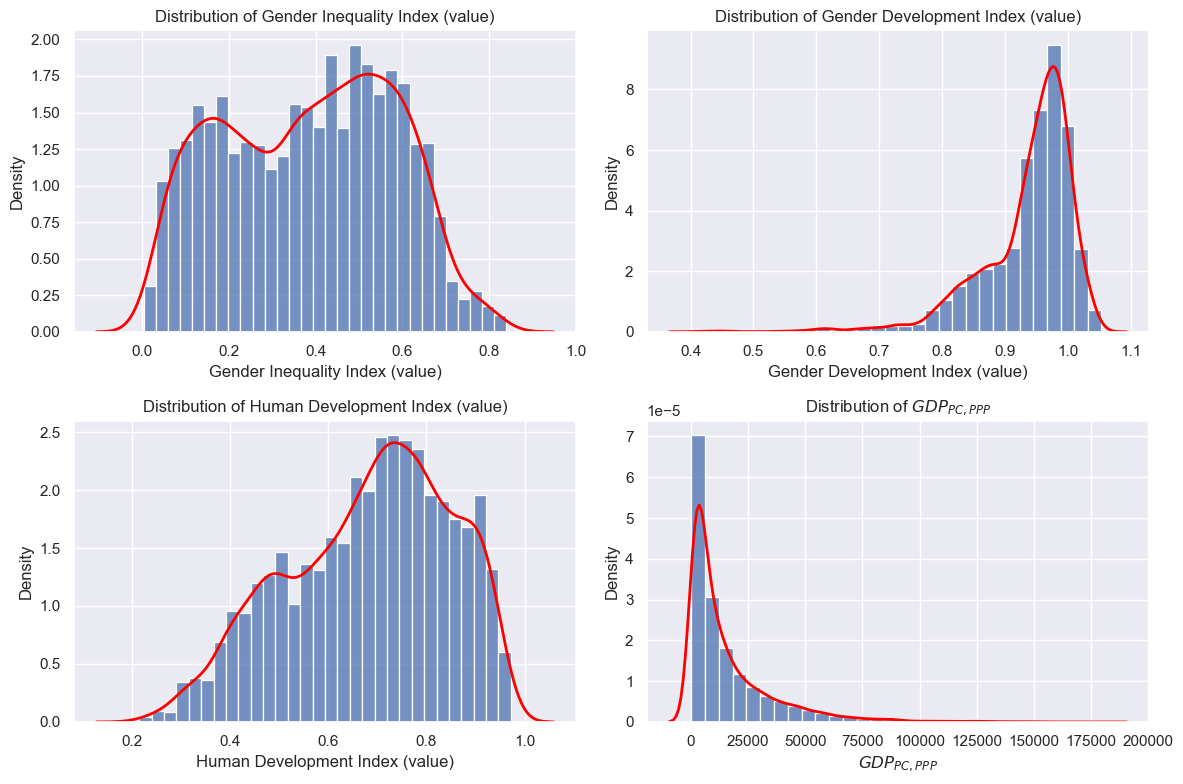

In [59]:
fig, ax = plt.subplots(2,2,figsize=(12, 8))
sns.histplot(data=GII, x='Gender Inequality Index (value)', bins=30, stat="density", ax=ax[0,0])
sns.kdeplot(data=GII, x='Gender Inequality Index (value)', color="red", lw=2, ax=ax[0,0])
ax[0,0].set_xlabel('Gender Inequality Index (value)')
ax[0,0].set_ylabel('Density')
ax[0,0].set_title('Distribution of Gender Inequality Index (value)')

sns.histplot(data=GDI, x='Gender Development Index (value)', bins=30, stat="density", ax=ax[0,1])
sns.kdeplot(data=GDI, x='Gender Development Index (value)', color="red", lw=2, ax=ax[0,1])
ax[0,1].set_xlabel('Gender Development Index (value)')
ax[0,1].set_ylabel('Density')
ax[0,1].set_title('Distribution of Gender Development Index (value)')

sns.histplot(data=HDI, x='Human Development Index (value)', bins=30, stat="density", ax=ax[1,0])
sns.kdeplot(data=HDI, x='Human Development Index (value)', color="red", lw=2, ax=ax[1,0])
ax[1,0].set_xlabel('Human Development Index (value)')
ax[1,0].set_ylabel('Density')
ax[1,0].set_title('Distribution of Human Development Index (value)')

sns.histplot(data=GDP, x='GDP', bins=30, stat="density", ax=ax[1,1])
sns.kdeplot(data=GDP, x='GDP', color="red", lw=2, ax=ax[1,1])
ax[1,1].set_xlabel(r'$GDP_{PC,PPP}$')
ax[1,1].set_ylabel('Density')
ax[1,1].set_title(r'Distribution of $GDP_{PC,PPP}$')

plt.tight_layout()
plt.savefig(image_path + 'Distribution.pdf', dpi=1200, bbox_inches='tight')
plt.show()

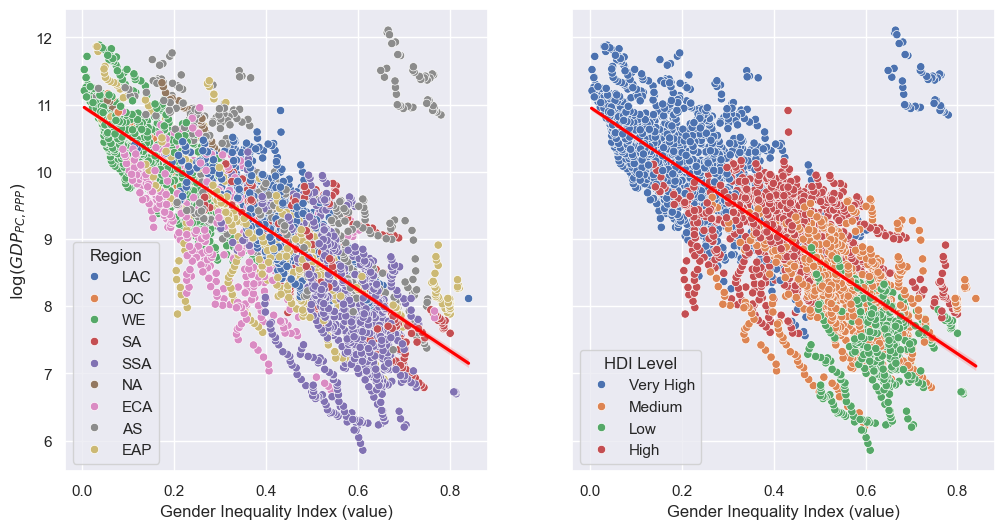

                                         Gender Inequality Index (value)_shifted  \
Gender Inequality Index (value)_shifted                                 1.000000   
logGDP                                                                 -0.779201   

                                           logGDP  
Gender Inequality Index (value)_shifted -0.779201  
logGDP                                   1.000000  


In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot with trend line
sns.scatterplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii']+'_shifted', y='logGDP', hue='region', ax=ax[0])
sns.regplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii']+'_shifted', y='logGDP', scatter=False, ax=ax[0], color='red', line_kws={"label": "Trend Line"})
ax[0].legend(title='Region')
ax[0].set_xlabel('Gender Inequality Index (value)')
ax[0].set_ylabel(r'$\log (GDP_{PC,PPP})$')

sns.scatterplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii']+'_shifted', y='logGDP', hue='hdicode',ax=ax[1])
sns.regplot(data=PrepareData(GDP_GII,HDR_idx['gii']), x=HDR_idx['gii'], y='logGDP', scatter=False, ax=ax[1], color='red', line_kws={"label": "Trend Line"})
ax[1].legend(title='HDI Level')
ax[1].set_xlabel('Gender Inequality Index (value)')
ax[1].set_ylabel(r'$\log (GDP_{PC,PPP})$')

plt.savefig(image_path + 'GDP_GII.pdf', dpi=1200, bbox_inches='tight')
plt.show()

C = PrepareData(GDP_GII,HDR_idx['gii'])
C = C[[HDR_idx['gii']+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())

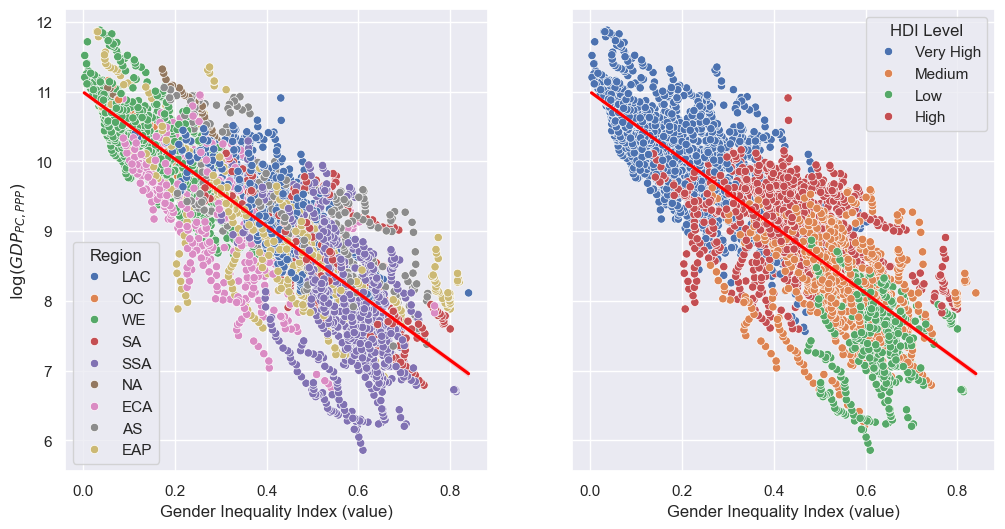

                                         Gender Inequality Index (value)_shifted  \
Gender Inequality Index (value)_shifted                                 1.000000   
logGDP                                                                 -0.836058   

                                           logGDP  
Gender Inequality Index (value)_shifted -0.836058  
logGDP                                   1.000000  


In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot with trend line
sns.scatterplot(data=Panel_GII, x=HDR_idx['gii']+'_shifted', y='logGDP', hue='region', ax=ax[0])
sns.regplot(data=Panel_GII, x=HDR_idx['gii'], y='logGDP', scatter=False, ax=ax[0], color='red', line_kws={"label": "Trend Line"})
ax[0].legend(title='Region')
ax[0].set_xlabel('Gender Inequality Index (value)')
ax[0].set_ylabel(r'$\log (GDP_{PC,PPP})$')

sns.scatterplot(data=Panel_GII, x=HDR_idx['gii']+'_shifted', y='logGDP', hue='hdicode',ax=ax[1])
sns.regplot(data=Panel_GII, x=HDR_idx['gii'], y='logGDP', scatter=False, ax=ax[1], color='red', line_kws={"label": "Trend Line"})
ax[1].legend(title='HDI Level')
ax[1].set_xlabel('Gender Inequality Index (value)')
ax[1].set_ylabel(r'$\log (GDP_{PC,PPP})$')

plt.savefig(image_path + 'GDP_GII_noAS.pdf', dpi=1200, bbox_inches='tight')
plt.show()

C = Panel_GII[[HDR_idx['gii']+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())

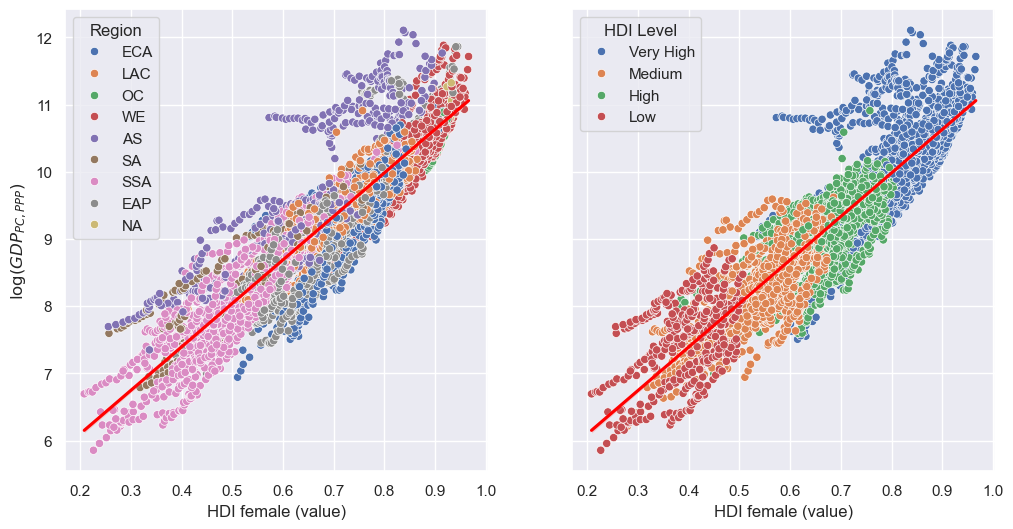

                            HDI female (value)_shifted   logGDP
HDI female (value)_shifted                     1.00000  0.91137
logGDP                                         0.91137  1.00000


In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot with trend line
sns.scatterplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', hue='region', ax=ax[0])
sns.regplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', scatter=False, ax=ax[0], color='red', line_kws={"label": "Trend Line"})
ax[0].legend(title='Region')
ax[0].set_xlabel('HDI female (value)')
ax[0].set_ylabel(r'$\log (GDP_{PC,PPP})$')

sns.scatterplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', hue='hdicode',ax=ax[1])
sns.regplot(data=Panel_GDI, x='HDI female (value)'+'_shifted', y='logGDP', scatter=False, ax=ax[1], color='red', line_kws={"label": "Trend Line"})
ax[1].legend(title='HDI Level')
ax[1].set_xlabel('HDI female (value)')
ax[1].set_ylabel(r'$\log (GDP_{PC,PPP})$')


plt.savefig(image_path + 'GDP_HDI_female.pdf', dpi=1200, bbox_inches='tight')
plt.show()

C = Panel_GDI[['HDI female (value)'+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())

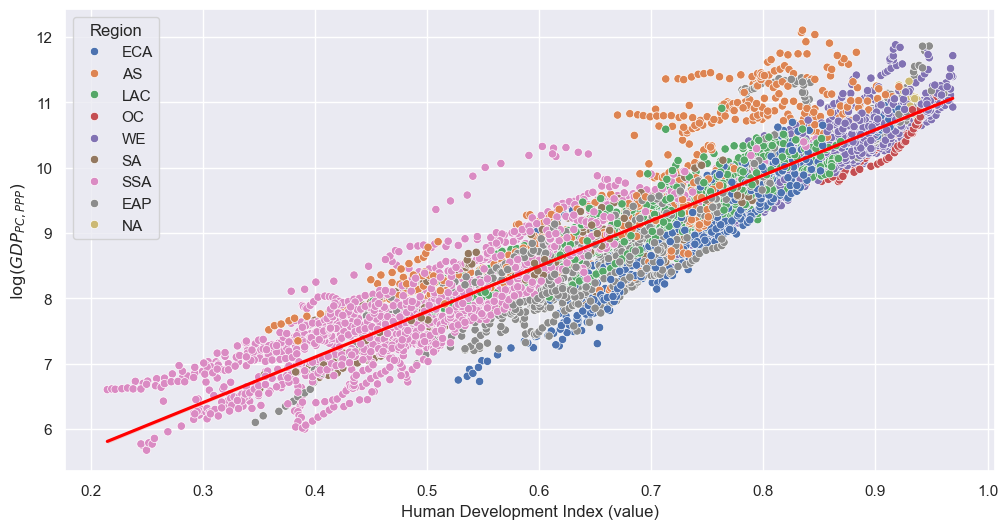

                                         Human Development Index (value)_shifted  \
Human Development Index (value)_shifted                                 1.000000   
logGDP                                                                  0.927144   

                                           logGDP  
Human Development Index (value)_shifted  0.927144  
logGDP                                   1.000000  


In [63]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_HDI, x=HDR_idx['hdi']+'_shifted', y='logGDP', hue='region',)
sns.regplot(data=Panel_HDI, x=HDR_idx['hdi']+'_shifted', y='logGDP', scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.xlabel('Human Development Index (value)')
plt.legend(title='Region')

plt.savefig(image_path + 'GDP_HDI.pdf', dpi=1200, bbox_inches='tight')
plt.show()

C = Panel_HDI[[HDR_idx['hdi']+'_shifted','logGDP']]
C = C.dropna()
print(C.corr())


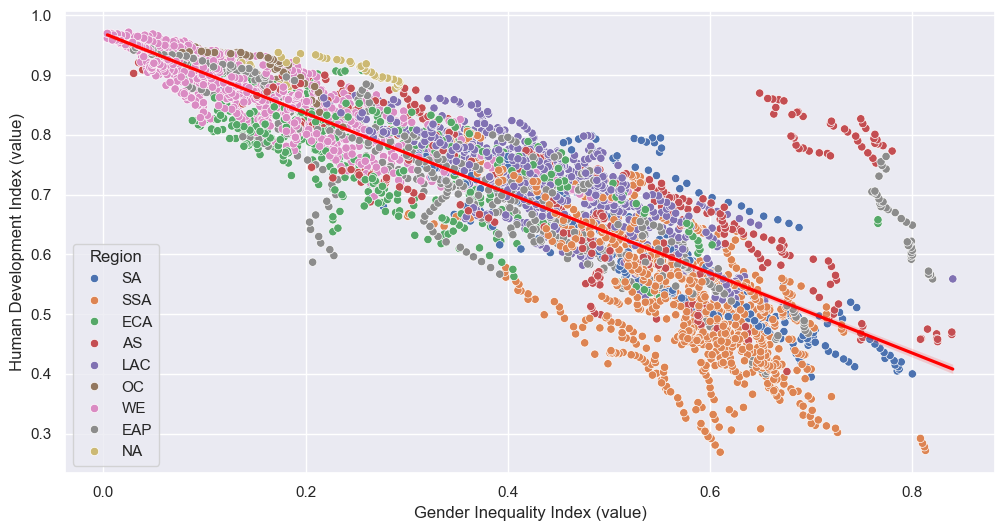

                                         Gender Inequality Index (value)_shifted  \
Gender Inequality Index (value)_shifted                                 1.000000   
Human Development Index (value)                                        -0.868187   

                                         Human Development Index (value)  
Gender Inequality Index (value)_shifted                        -0.868187  
Human Development Index (value)                                 1.000000  


In [64]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_HDI_GII, x=HDR_idx['gii']+'_shifted', y=HDR_idx['hdi'], hue='region')
sns.regplot(data=Panel_HDI_GII, x=HDR_idx['gii']+'_shifted', y=HDR_idx['hdi'], scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(HDR_idx['hdi'])
plt.xlabel(HDR_idx['gii'])
plt.legend(title='Region')

plt.savefig(image_path + 'HDI_GII.pdf', dpi=1200, bbox_inches='tight')
plt.show()

C = Panel_HDI_GII[[HDR_idx['gii']+'_shifted',HDR_idx['hdi']]]
C = C.dropna()
print(C.corr())

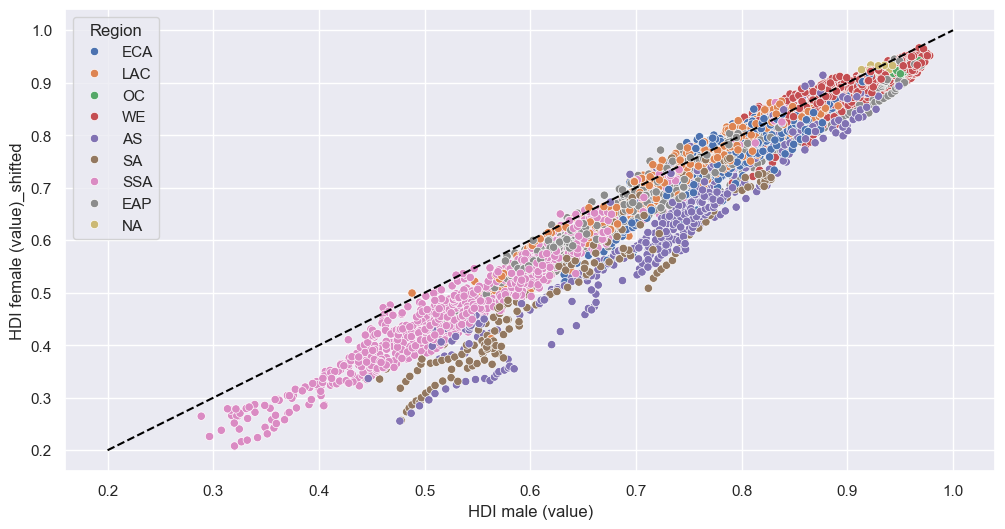

In [65]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_GDI, y='HDI female (value)'+'_shifted', x='HDI male (value)', hue='region')
plt.plot([0.2, 1], [0.2, 1], color='black', linestyle='--')
plt.legend(title='Region')

plt.savefig(image_path + 'HDI_Female_vs_Male.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [66]:
M = Panel_GDI.copy() # Drop rows with NaN values
M.dropna(subset = ['HDI female (value)','HDI male (value)'])
np.corrcoef(M['HDI female (value)'], M['HDI male (value)'])

array([[1.        , 0.97706484],
       [0.97706484, 1.        ]])

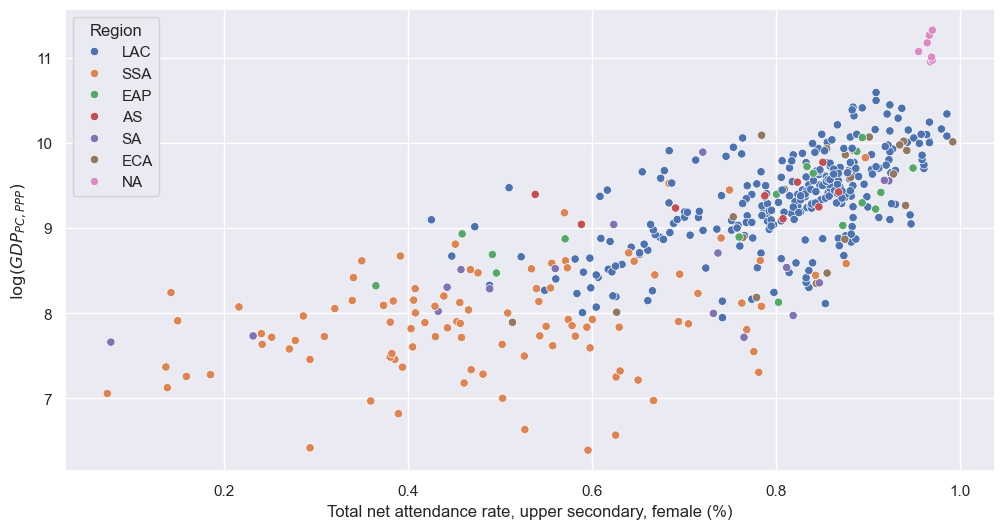

In [67]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Panel_GII_Schooling, x='Total net attendance rate, upper secondary, female (%)', y='logGDP', hue='region')
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.legend(title='Region')
plt.show()